# Basic Tutorial For Using the Dataset

In [1]:
# Import the Data
import base_dataset as dataset

# Import other packages needed for this tutorial.
import torchvision
import IPython
import torch

from torchvision import transforms
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image

d:\Coding Applications\miniconda\envs\fyp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'2.2.1'

### Set up the Dataset
- Define the path to your dataset folder and the path to your annotation json file. 
- Note: my directory definition may be different from yours.

In [2]:
train_dir = "data/train"
train_coco = "data/annotations/train.json"

val_dir = "data/val"
val_coco = "data/annotations/val.json"

# Note other transformations are not implemented as of this moment.
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Define the dataset class
train_dataset = dataset.RadioGalaxyNET(root=train_dir,
                          annFile=train_coco,
                          transforms=get_transform(train=True)
                          ) 

val_dataset = dataset.RadioGalaxyNET(root=val_dir,
                          annFile=val_coco,
                          transforms=get_transform(train=False)
                          ) 

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Visualize Data

In [3]:
# You can check for the Categorical definition here. 
train_dataset.display_categories()

id 1: FR-II
id 2: FR-I
id 3: FR-X
id 4: R


In [5]:
# You can visualze image and segmentation here
#html = train_dataset.display_image(1)
#IPython.display.HTML(html)

In [4]:
train_dataset.__getitem__(2)


(tensor([[[0.7255, 0.7490, 0.7608,  ..., 0.1333, 0.5020, 1.0000],
          [0.5804, 0.6000, 0.6196,  ..., 0.0000, 0.0000, 0.2745],
          [0.4275, 0.4314, 0.4471,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

### Training

#### Define Dataloader

In [5]:
# Device Selection
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# collate_fn needs for batch
def collate_fn(batch):
    images = []
    annotations = []
    for img, ann in batch:
        images.append(img)
        annotations.append(ann)
    return images, annotations

# Batch size
train_batch_size = 10

# Define DataLoader for some reason my dataloader can only be = 0, please try different number and let me know how you guys goes. 
data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

#### Define Model

- I followed the tutorial set out here for Fast RCNN: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [7]:
# I believe Fast RCNN recognises background as a class.
num_classes = 5
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.005,
                            momentum=0.9, 
                            weight_decay=0.0005)

len_dataloader = len(data_loader)

#### Define the training iterations

-  This training loop is only for object detection

In [8]:
import os
from engine import train_one_epoch, evaluate
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

Epoch: [0]  [   0/1959]  eta: 2:30:28  lr: 0.000010  loss: 3.9683 (3.9683)  loss_classifier: 1.6753 (1.6753)  loss_box_reg: 0.1456 (0.1456)  loss_mask: 2.1230 (2.1230)  loss_objectness: 0.0218 (0.0218)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 4.6085  data: 0.0100  max mem: 907
Epoch: [0]  [  10/1959]  eta: 0:15:28  lr: 0.000060  loss: 3.3938 (3.5286)  loss_classifier: 1.4637 (1.4434)  loss_box_reg: 0.0398 (0.0662)  loss_mask: 1.9871 (1.9569)  loss_objectness: 0.0373 (0.0592)  loss_rpn_box_reg: 0.0027 (0.0029)  time: 0.4763  data: 0.0075  max mem: 1185
Epoch: [0]  [  20/1959]  eta: 0:08:51  lr: 0.000110  loss: 2.7322 (2.6954)  loss_classifier: 0.9318 (0.9859)  loss_box_reg: 0.0377 (0.0525)  loss_mask: 1.4532 (1.5968)  loss_objectness: 0.0471 (0.0581)  loss_rpn_box_reg: 0.0013 (0.0020)  time: 0.0575  data: 0.0067  max mem: 1185
Epoch: [0]  [  30/1959]  eta: 0:06:31  lr: 0.000160  loss: 1.1140 (2.1319)  loss_classifier: 0.1138 (0.6939)  loss_box_reg: 0.0377 (0.0486)  loss_mask: 0.8273 (1

#### Visualizing Results

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


'\n'

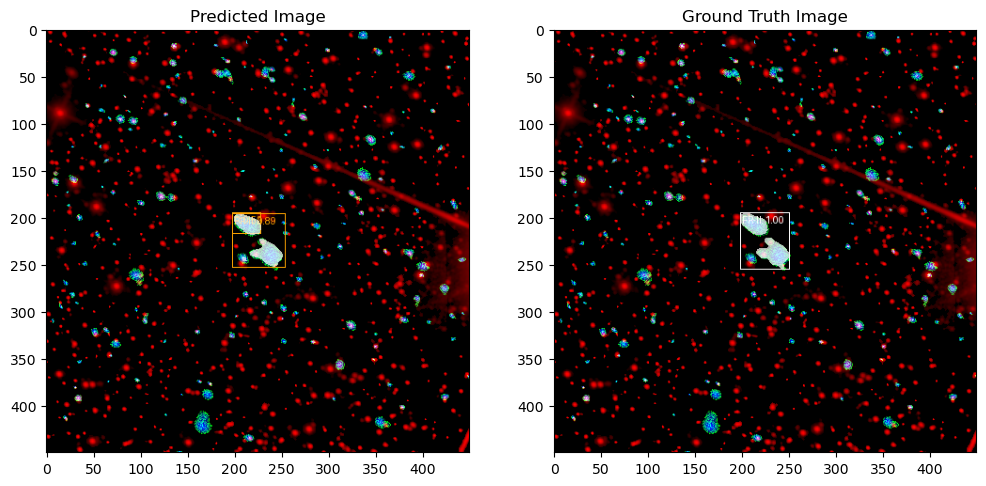

In [13]:
# Define an index
img_index = 2
# Define Testing Dataset
test_dir = "data/test"
test_coco = "data/annotations/test.json"

test_dataset = dataset.RadioGalaxyNET(root=test_dir,
                          annFile=test_coco,
                          transforms=get_transform(train=False)
                          ) 

# Format images for visualization

image = test_dataset.__getitem__(img_index)[0]
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
image_pred = test_dataset.__getitem__(img_index)[0].to(device)

# Set the model to evaluation mode
model.eval()
predictions =model([image_pred, ])

# Define classification and segmentation threshold
class_th = 0.4
segment_th = 0.7
idxToLabel = {1: 'FR-II', 2: 'FR-I', 3: 'FR-X', 4:'R'}

pred = predictions[0]

score_list = torch.nonzero(pred["scores"] > class_th)
pred_labels = []

# Prediction
i = 0
for item in pred['labels'][score_list]:
    class_name = idxToLabel[item.item()]
    class_score = pred["scores"][score_list[i]].item()
    class_score = format(class_score, ".2f")
    label_str = class_name + ": " + class_score
    pred_labels.append(label_str)
    i += 1

pred_boxes = pred["boxes"][score_list]
output_image = draw_bounding_boxes(image, pred_boxes[:,0], pred_labels, colors="orange")
masks = (pred["masks"][score_list] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks[0], alpha=0.7, colors="white")

# Ground Truth

__,g_truth = test_dataset.__getitem__(img_index)


i = 0
pred_labels_gt = []
for item in g_truth['labels']:
    class_name = idxToLabel[item.item()]
    class_score = 1.00
    class_score = format(class_score, ".2f")
    label_str = class_name + ": " + class_score
    pred_labels_gt.append(label_str)
    i += 1

pred_boxes_gt = g_truth["boxes"].long()

output_image_gt = draw_bounding_boxes(image, pred_boxes_gt, pred_labels_gt, colors="white")
masks_gt = (g_truth["masks"]>0).squeeze(1)
output_image_gt = draw_segmentation_masks(output_image_gt, masks_gt, alpha=0.7, colors="white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(output_image.permute(1, 2, 0))
ax1.set_title('Predicted Image')
ax2.imshow(output_image_gt.permute(1, 2, 0))
ax2.set_title('Ground Truth Image')
"""
"""

In [13]:
pred_boxes[:,0]

tensor([[192.3604, 206.4531, 240.6209, 239.0266]], device='cuda:0',
       grad_fn=<SelectBackward0>)